In [1]:
import pandas as pd
import numpy as np

# DataViz
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly.colors as pc
import pycountry_convert as pc

# Associaton Nominal
from dython.nominal import associations

# Train-Test split and CrossVal
from sklearn.model_selection import GridSearchCV,StratifiedKFold, train_test_split, cross_validate, cross_val_score
from sklearn.preprocessing import OneHotEncoder


# Scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler 

# Transfrom & One-Hot Encoding
from sklearn.compose import ColumnTransformer
from category_encoders import OrdinalEncoder, BinaryEncoder


# Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

# Metrics Evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, fbeta_score, accuracy_score, recall_score, precision_score, precision_recall_curve, make_scorer
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay

# Handling Imbalance
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

import joblib
import warnings
warnings.filterwarnings('ignore')

## **Business Problem & Understanding**

---

- **Context :**

Bisnis perhotelan merupakan bisnis yang sangat kompetitif. Keberhasilan bisnis ini bergantung pada kepuasan pelanggan dan kualitas layanan yang diberikan kepada pelanggan. Bisnis perhotelan juga merupakan bisnis musiman dengan permintaan bervariasi sesuai musim nya. Pendapatan bisnis ini bergantung pada pemesanan setiap tamu dan pemesanan dapat berupa pemesanan langsung ke hotel atau travel agent baik yang konvensional ataupun online.

Selama dekade terakhir, telah terjadi peningkatan yang pesat dalam bisnis perhotelan yang dipicu dengan perkembangan industri pariwisata global. **Menurut data dari World Tourism Organization, peningkatan volume wisatawan internasional dari 25 juta pada tahun 1950 menjadi 1,4 miliar pada tahun 2019**. **(Source: [Link](https://www.e-unwto.org/doi/epdf/10.18111/9789284422456))**

- **Problem Statement :**

Namun, pertumbuhan bisnis perhotelan ini juga menghadirkan tantangan baru bagi manajer hotel, terutama dalam hal mengelola `booking cancellation` yang dapat berdampak signifikan pada pendapatan dan efisiensi operasional. Proses manual dalam manajemen hotel, terutama dalam hal pengelolaan reservasi dan penentuan harga, sering kali menjadi hambatan signifikan di tengah dinamika industri yang cepat berubah. Dalam sebuah studi mengungkapkan bahwa hotel yang masih menggunakan metode manual untuk manajemen reservasi **mengalami rata-rata tingkat pembatalan sebesar 8%** , **pada pemesanan daring sebesar 17%**, **diikuti oleh pemesanan luring (12%)** dan **pemesanan travel agency (4%)**, sehingga berdampak negatif pada pendapatan dan efisiensi operasional. **(Source: [Link](https://www.emerald.com/insight/content/doi/10.1108/ijchm-08-2017-0509/full/html#:~:text=Evidence%20based%20on%20233%2C000%20bookings%20shows%20that%20the%20overall%20cancellation%20rate%20is%208%20per%20cent.%20Cancellation%20rates%20are%20highest%20for%20online%20bookings%20(17%20per%20cent)%2C%20followed%20by%20offline%20bookings%20(12%20per%20cent)%20and%20travel%20agency%20bookings%20(4%20per%20cent)))**. 

Dalam mengatasi masalah ini, penting untuk mengembangkan teknologi model machine learning yang dapat memperkirakan `booking cancellation`. Memprediksi `booking cancellation` dapat mencegah hotel kehilangan/pengurangan pendapatan (jika hotel memiliki ketentuan pembatalan booking yang dimana uang customer direfund full 100%), pengalokasian sumber daya yang tidak efisien, dan overbooking yang berujung pada ketidakpuasan pelanggan.

- **Goals :**

Berdasarkan permasalahan diatas, dengan adanya model machine learning ini yang dapat memprediksi kemungkinan seorang pelanggan akan membatalkan bookingnya atau tidak berdasarkan karakteristik yang ada. Memudahkan pihak manajemen hotel melakukan tindakan proaktif untuk mengurangi dampak pembatalan, seperti penawaran khusus untuk mengisi kembali kamar yang dibatalkan atau penyesuaian strategi harga untuk mengoptimalkan pendapatan.

- **Stakeholder :**

Stakeholders untuk project ini adalah:

1. Manajemen Hotel
   * Kendala : Kesulitan dalam merencanakan ketersediaan kamar dan pendapatan akibat pembatalan mendadak yang mengakibatkan kamar kosong dan penurunan pendapatan.
   * Benefit : Dapat merencanakan pengelolaan kamar dan memaksimalkan pendapatan melalui overbooking terkontrol.

- **Analytic Approach :**

`1` : Canceled (Yes) --> Positive

`0` : Not Canceled (No) --> Negative

`Type 1 error : False Positive` --> **Resiko Biaya Operasional yang sia-sia + Kehilangan Pelanggan**. (Diprediksi Canceled, tetapi aktual nya Not Canceled)

`Type 2 error : False Negative` --> **Resiko Kekosongan Kamar + Overbooking**. (Diprediksi Not Canceled, tetapi aktual nya Canceled)

Berdasarkan konsekuensinya, `False Positive` memiliki dampak yang lebih merugikan dibandingkan dengan `False  Negative`. **Hal ini disebabkan oleh cost yang lebih tinggi dengan biaya operasional yang sia sia dan kehilangan pelanggan yang mempengaruhi kepuasaan pelanggan akibat yang kesalahan prediksi tamu membatalkan reservasi tetapi nyatanya tamu melakukan reservasi**. Kehilanggan pelanggan akan:

- Mengeluarkan biaya untuk mendapatkan pelanggan baru **(Customer Acquisition Cost)** 
- Berdampak secara jangka panjang akibat kepuasaan pelanggan yang dapat memutuskan untuk tidak memesan di hotel tersebut di masa mendatang **(Customer Lifetime Value Loss)**

Di sektor perhotelan, mengatasi tamu meskipun overbooking sangat beresiko karna mempengaruhi kepuasaan pelangga tetapi overbooking lebih mudah dikontrol dibandingkan dengan resiko kehilanggan loyalitas pelanggan yang dapat mempengaruhi pendapatan hotel dalam jangka panjang, karena tamu yang ingin tetap reservasi meskipun overbooking bisa diatasi dengan memberikan kompensasi kepada pelanggan akibat **[overbooking dengan tetap memaksimalkan pendapatan](https://www.channelrush.com/blog/what-is-overbooking-in-hotel-management#:~:text=By%20mastering%20this%20process%2C%20hotels%20can%20not%20only%20maximize%20their%20revenue%20potential%20from%20repeat%20guests%20but%20also%20maintain%20high%20levels%20of%20guest%20satisfaction%20despite%20the%20challenges%20posed%20by%20overbooking.)**. Oleh karena itu, penting untuk meminimalkan kesalahan `False Positive` untuk mengurangi kerugian operasional dan menjaga loyalitas pelanggan.

- **Metric Evaluation :**

Pada saat yang sama kedua kesalahan prediksi tersebut sama sama berdampak pada kehilangan pendapatan. Tetapi, dinilai berdasarkan konsekuensi nya `False Positive` berdampak pada kerugian yang lebih besar seperti **menambah biaya Customer Acquistion** dan juga **kehilangan Customer Lifetime Value**. Maka dari itu, perlu untuk menilai kinerja model dengan metrics yang seimbang dikeduanya dengan lebih menghindari `False Positive` yang berlebih. Pada kasus ini, kita dapat menggunakan **[F0.5 Score](https://mlexplained.blog/2023/01/09/when-to-use-f2-or-f0-5-score-f-beta-score/#:~:text=This%20enables%20one%20to%20choose%20an%20appropriate%20beta%20value%20to%20tune%20for%20the%20task%20at%20hand.%20If%20you%20want%20to%20minimize%20false%20positives%2C%20you%20want%20to%20increase%20the%20weight%20of%20precisions%2C%20so%20you%20should%20choose%20a%20value%20of%20beta%20less%20than%201%2C%20typically%200.5%20is%20chosen%20and%20is%20called%20F0.5%20score.)** untuk digunakan sebagai metrics kinerja model.

**`F.05 Method`**

**Evaluation berdasarkan F.05 Score** merupakan langkah untuk mengurangi sebanyak-banyaknya `False Positive` yang terjadi, sambil tetap mempertimbangkan recall. Menggunakan F0.5 score menjadi pilihan yang baik untuk mengevaluasi metrik hasil model prediksi dalam konteks `booking cancellation`, terutama ketika ingin mengurangi dampak dari pembatalan pemesanan pada detik-detik terakhir yang tidak terdeteksi oleh model. Jika F0.5 score rendah, ini menunjukkan bahwa banyak tamu yang diprediksi melakukan pembatalan tapi nyatanya melakukan reservasi pada menit-menit terakhir tanpa terdeteksi, yang dapat mengakibatkan hilangnya pelanggan dan pendapatan. Mengingat ketidakpastian perilaku tamu yang dinamis, **memaksimalkan F0.5 score menjadi bagian penting dari strategi manajemen hotel untuk memastikan bahwa cost dapat diminimalkan, dengan lebih fokus pada penghindaran kehilangan pelangga**n.

`F0.5 Score` --> mengukur proporsi rata-rata antara tamu yang benar-benar melakukan pembatalan booking dan melakukan reservasi, dengan penekanan pada kesalahan `False Positive`. Ini memberikan gambaran tentang seberapa baik model dalam menjaga keseimbangan antara precision dan recall, tetapi dengan lebih banyak perhatian pada precision.

$$
F0.5 = (1 + 0.5^2) \cdot \frac{\text{Precision} \cdot \text{Recall}}{(0.5^2 \cdot \text{Precision}) + \text{Recall}}
$$

Dengan F.05 Score yang tinggi, manajemen hotel memiliki kesempatan untuk mengambil tindakan proaktif untuk mencegah kehilangan pelanggan dengan menawarkan opsi rebooking atau reschedule. Hal ini membantu hotel dalam mempertahankan pendapatan dan loyalitas pelanggan, sehingga membuat model prediksi `booking cancellation` menjadi alat yang efektif untuk membuat strategi manajemen hotel.

## **Data Understanding**

---

- ## **Data Description**

**Data Source :**

Kumpulan data ini berasal dari Kaggle dan Research yang berisi informasi pemesanan untuk hotel yang berlokasi di Portugal, dan mencakup informasi mengenai reservasi kamar untuk masing-masing pelanggan. Terdiri dari 119,390 baris dan 32 kolom. **([Hotel Booking Demand](https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand/data))** and **([Research Hotel Booking Demand Dataset](https://www.sciencedirect.com/science/article/pii/S2352340918315191))**

| Attribute                     | Data Type | Description                                                                                                      |
|-------------------------------|-----------|------------------------------------------------------------------------------------------------------------------|
| hotel                         | Object    | Type of hotel (Resort Hotel or City Hotel)                                                                       |
| is_canceled                   | Integer   | Whether the booking was canceled (1) or not (0)                                                                  |
| lead_time                     | Integer   | Number of days between booking date and arrival date                                                             |
| arrival_date_year             | Integer   | Year of arrival date                                                                                             |
| arrival_date_month            | Object    | Month of arrival date (January - December)                                                                       |
| arrival_date_week_number      | Integer   | Week number of arrival date                                                                                      |
| arrival_date_day_of_month     | Integer   | Day of the month of the arrival date                                                                             |
| stays_in_weekend_nights       | Integer   | Number of weekend nights (Saturday and Sunday)                                                                   |
| stays_in_week_nights          | Integer   | Number of week nights (Monday to Friday)                                                                         |
| adults                        | Integer   | Number of adults                                                                                                 |
| children                      | Float     | Number of children                                                                                               |
| babies                        | Integer   | Number of babies                                                                                                 |
| meal                          | Object    | Type of meal booked (BB, HB, FB, SC)                                                                             |
| country                       | Object    | Country of origin of the customer                                                                                |
| market_segment                | Object    | Market segment designation (e.g., Direct, Corporate, Online TA)                                                  |
| distribution_channel          | Object    | Booking distribution channel (e.g., Direct, TA/TO)                                                               |
| is_repeated_guest             | Integer   | Whether the customer is a repeated guest (1) or not (0)                                                          |
| previous_cancellations        | Integer   | Number of previous cancellations                                                                                 |
| previous_bookings_not_canceled| Integer   | Number of previous bookings not canceled                                                                         |
| reserved_room_type            | Object    | Code of room type reserved                                                                                       |
| assigned_room_type            | Object    | Code for the type of room assigned to the booking                                                                |
| booking_changes               | Integer   | Number of changes made to the booking                                                                            |
| deposit_type                  | Object    | Type of deposit  to guarantee the booking (No Deposit, Non Refund, Refundable)                                   |
| agent                         | Float     | ID of the travel agency that made the booking                                                                    |
| company                       | Float     | ID of the company/entity that made the booking                                                                   |
| days_in_waiting_list          | Integer   | Number of days the booking was in the waiting list                                                               |
| customer_type                 | Object    | Type of booking (Contract, Group, Transient, Transient-Party)                                                    |
| adr                           | Float     | Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights|
| required_car_parking_spaces   | Integer   | Number of car parking spaces required                                                                            |
| total_of_special_requests     | Integer   | Total number of special requests made (e.g. twin bed or high floor)                                              |
| reservation_status            | Object    | Reservation last status (Canceled, Check-Out, No-Show)                                                           |
| reservation_status_date       | Object    | Date at which the last status was set                                                                            |


In [2]:
df = pd.read_csv('dataset_hotel_bookings.csv')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
pd.set_option('display.max_colwidth', 120)
listItem = []
for col in df.columns :
    listItem.append( [col, df[col].nunique(), df[col].unique()])
tabel_desc = pd.DataFrame(columns=['Nama Kolom', 'Jumlah Total Unique', 'Sampel Unique'],
                     data=listItem)
tabel_desc

,Nama Kolom,Jumlah Total Unique,Sampel Unique
0,hotel,2,"[Resort Hotel, City Hotel]"
1,is_canceled,2,"[0, 1]"
2,lead_time,479,"[342, 737, 7, 13, 14, 0, 9, 85, 75, 23, 35, 68, 18, 37, 12, 72, 127, 78, 48, 60, 77, 99, 118, 95, 96, 69, 45, 40, 15..."
3,arrival_date_year,3,"[2015, 2016, 2017]"
4,arrival_date_month,12,"[July, August, September, October, November, December, January, February, March, April, May, June]"
5,arrival_date_week_number,53,"[27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 1, 2, 3..."
6,arrival_date_day_of_month,31,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]"
7,stays_in_weekend_nights,17,"[0, 1, 2, 4, 3, 6, 13, 8, 5, 7, 12, 9, 16, 18, 19, 10, 14]"
8,stays_in_week_nights,35,"[0, 1, 2, 3, 4, 5, 10, 11, 8, 6, 7, 15, 9, 12, 33, 20, 14, 16, 21, 13, 30, 19, 24, 40, 22, 42, 50, 25, 17, 32, 26, 1..."
9,adults,14,"[2, 1, 3, 4, 40, 26, 50, 27, 55, 0, 20, 6, 5, 10]"


- ## **Data Pre-processing**

### **Checking Missing Value**

In [4]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2)]);

nulldata = pd.DataFrame(columns=['Columns', 'dataType', 'null', 'nullPercentage'],
                     data=listItem)
nulldata

,Columns,dataType,null,nullPercentage
0,hotel,object,0,0.00
1,is_canceled,int64,0,0.00
2,lead_time,int64,0,0.00
3,arrival_date_year,int64,0,0.00
4,arrival_date_month,object,0,0.00
5,arrival_date_week_number,int64,0,0.00
6,arrival_date_day_of_month,int64,0,0.00
7,stays_in_weekend_nights,int64,0,0.00
8,stays_in_week_nights,int64,0,0.00
9,adults,int64,0,0.00


### **Handling Missing Value**

Dalam mengatasi missing value yang terjadi pada kolom Agent, Company dan juga Country yang masing-masing bernilai 0.41%, 12.69% dan 94.31% dari total data, langkah yang dapat dilakukan adalah :

- **Dropping kolom `Agent` dan `Company` didrop**, dikarenakan kolom tersebut kurang relevan dan juga bersifat personal/confidential. Ditambah nilai missing value nya cukup besar yang tidak memungkinkan untuk dilakukan imputasi data untuk mengisi nilai NULL.
- **Dropping rows dengan nilai NULL pada kolom `Country`**, dengan nilai NULL yang cukup kecil (0.41%) hal ini tidak akan berpengaruh signifikan terhadap analisis yang akan dilakukan.

In [5]:
df.drop(['company','agent'], axis=1, inplace = True)
df.dropna(inplace =True)

In [6]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2)]);

cleandata = pd.DataFrame(columns=['Columns', 'dataType', 'null', 'nullPercentage'],
                     data=listItem)

In [7]:
display(cleandata)
display(df.shape)

,Columns,dataType,null,nullPercentage
0,hotel,object,0,0.0
1,is_canceled,int64,0,0.0
2,lead_time,int64,0,0.0
3,arrival_date_year,int64,0,0.0
4,arrival_date_month,object,0,0.0
5,arrival_date_week_number,int64,0,0.0
6,arrival_date_day_of_month,int64,0,0.0
7,stays_in_weekend_nights,int64,0,0.0
8,stays_in_week_nights,int64,0,0.0
9,adults,int64,0,0.0


(118898, 30)

### **Checking for Duplicated Values**

In [8]:
df.duplicated().sum()

31984

In [9]:
duplicated_sample = df[df.duplicated()].head(10)
duplicated_sample

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,A,0,No Deposit,0,Transient,98.00,0,1,Check-Out,2015-07-03
22,Resort Hotel,0,72,2015,July,27,1,2,4,2,...,A,1,No Deposit,0,Transient,84.67,0,1,Check-Out,2015-07-07
43,Resort Hotel,0,70,2015,July,27,2,2,3,2,...,E,0,No Deposit,0,Transient,137.00,0,1,Check-Out,2015-07-07
138,Resort Hotel,1,5,2015,July,28,5,1,0,2,...,D,0,No Deposit,0,Transient,97.00,0,0,Canceled,2015-07-01
200,Resort Hotel,0,0,2015,July,28,7,0,1,1,...,A,0,No Deposit,0,Transient,109.80,0,3,Check-Out,2015-07-08
219,Resort Hotel,1,1,2015,July,28,8,0,1,2,...,A,0,No Deposit,0,Transient,104.72,0,1,Canceled,2015-07-08
256,Resort Hotel,0,91,2015,July,28,10,0,2,2,...,A,0,No Deposit,0,Transient,73.80,0,1,Check-Out,2015-07-12
261,Resort Hotel,0,30,2015,July,28,10,2,2,2,...,F,0,No Deposit,0,Transient-Party,197.00,0,1,Check-Out,2015-07-14
353,Resort Hotel,0,98,2015,July,29,13,1,1,2,...,A,0,No Deposit,0,Transient-Party,82.00,0,3,Check-Out,2015-07-15
372,Resort Hotel,0,40,2015,July,29,13,1,4,2,...,D,0,No Deposit,0,Transient,120.00,0,2,Check-Out,2015-07-18


**Duplicated Values** dalam dataset ini sepertinya disebabkan oleh kesamaan detail pemesanan, terutama di antara pemesanan dari `Country` PRT pada `Market Segment` "Groups" atau melalui `Distribution Channel` "TA/TO". Data Duplikat ini kemungkinan besar menggambarkan pemesanan Groups yang berulang atau pemesanan individu yang memiliki banyak kesamaan.

- ## **Data Limitation**

Dalam melakukan analisis dan juga pengembangan model prediksi diperlukan penerapan batasan pada sebuah dataset. Batasan ini diharapkan dapat membantu relevansi dan keandalan prediksi. Di bawah ini, beberapa penjelasan mengapa batasan ini dilakukan dan pengecualian tertentu diperlukan: 

**1. Lead Time Threshold: Focusing on Relevant Booking** 

- **Why?** --> `Lead time` mengacu pada waktu antara pemesanan dan kedatangan. `Lead Time` dalam pemesanan hotel biasanya berkisar antara **20 hingga 60 hari** **([Source](https://blog.axisrooms.com/hotel-booking-lead-time/#:~:text=The%20typical%20timeframe%20for%20booking%20hotels%20usually%20falls%20within%20the%20range%20of%2020%20to%2060%20days))**. Pemesanan dengan lead time lebih dari 60 hari cenderung lebih terkait dengan promosi atau acara khusus, yang jarang terjadi pada pemesanan reguler.

- **Lead Time Threshold Application** --> Menghilangkan pemesanan dengan **`lead time` >= 60** hari untuk fokus pada pemesanan yang lebih relevan.

**2. Zero Occupancy: Ensuring Data Consistency** 

- **Why?** --> Pemesanan dengan `adults`, `children`,`babies` tidak dapat mencapai 0 pada saat yang sama, hal ini tidak relevan adanya pemesanan tanpa tamu sama sekali.

- **Lead Time Threshold Application** --> Pemesanan dengan **`adults`, `children`, `babies` = 0** akan dihapus agar dataset berisi data yang konsisten dan relevan.

**3. ADR (Average Daily Rate) Threshold: Removing Unrealistic Data** 

- **Why?** --> Nilai `ADR` yang sangat tinggi atau rendah menunjukkan kesalahan data atau pemesanan yang tidak biasa (Outliers). Oleh karena itu, **ADR dibatasi pada rentang nilai antara 0 dan 1000** untuk memastikan harga yang realistis.

- **Lead Time Threshold Application** --> Menghapus pemesanan dengan **`ADR` < 0 atau > 1000** agar model hanya menggunakan data harga yang realistis.

In [10]:
# Data Limitation Filter
filter = (
     ~((df['children'] == 0) & (df['adults'] == 0) & (df['babies'] == 0)) & 
    ~((df['lead_time'] >= 60)) & 
    ~((df['adr'] < 0) | (df['adr'] > 1000))
)


df = df[filter]
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,C,0,No Deposit,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,A,0,No Deposit,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,A,0,No Deposit,0,Transient,98.00,0,1,Check-Out,2015-07-03
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,A,0,No Deposit,0,Transient,98.00,0,1,Check-Out,2015-07-03
6,Resort Hotel,0,0,2015,July,27,1,0,2,2,...,C,0,No Deposit,0,Transient,107.00,0,0,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119365,City Hotel,0,54,2017,August,35,27,3,5,1,...,G,0,No Deposit,0,Transient,266.75,0,1,Check-Out,2017-09-04
119380,City Hotel,0,44,2017,August,35,31,1,3,2,...,A,0,No Deposit,0,Transient,140.75,0,1,Check-Out,2017-09-04
119384,City Hotel,0,21,2017,August,35,30,2,5,2,...,A,0,No Deposit,0,Transient,96.14,0,2,Check-Out,2017-09-06
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,A,0,No Deposit,0,Transient,96.14,0,0,Check-Out,2017-09-06


**Based on Research and Domain Knowledge**

Kita sudah membatasi nilai-nilai pada dataset yang memungkinkan outlier dan tidak relevan dengan standar bisnis yang ada, sehingga dapat mengetahui kisaran nilai yang memungkinkan untuk menentukan `booking cancellation`. Dengan Pre-processing ini diharapkan dapat membawa hasil yang lebih baik dalam analisis dan prediksi

| **Variable** | **Range** |
| --- | --- |
| Lead Time | <= 60 |
| Guest (Adults, Children, Babies) | > 0 |
| ADR (Average Daily Rate) | 0 < ADR < 1000 | 

## **Exploratory Data Analysis**

---

**Analytic Question :**

1. Cancellation
- How many bookings were canceled?
- Which month have the highest number of cancelations?

2. Guest 
- Where do the guests come from?
- Which are the most busy month?
- How long do people stay at the hotels?

3. Market Segment
- Bookings by market segment
?



- ## **Cancellation**

### **How many bookings were canceled?**

In [11]:
canceled_data = df[df['is_canceled'] == 1]
canceled_counts = canceled_data['hotel'].value_counts().reset_index()
canceled_counts.columns = ['Hotel', 'Cancellations']

total_canceled = len(canceled_data)
total_not_canceled = len(df) - total_canceled

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Overall Booking Status", "Canceled Bookings by Hotel"),
    specs=[[{"type": "pie"}, {"type": "bar"}]]
)

fig.add_trace(
    go.Pie(
        labels=['Canceled', 'Not Canceled'],
        values=[total_canceled, total_not_canceled],
        textinfo='label+percent',
        insidetextorientation='radial',
        name="Overall Status"
    ),
    row=1, col=1
)

fig.add_trace(
    go.Bar(
        x=canceled_counts['Hotel'],
        y=canceled_counts['Cancellations'],
        text=canceled_counts['Cancellations'],
        textposition='outside',
        name="Canceled Bookings",
        marker=dict(color=['#636EFA', '#EF553B'])  # Warna berbeda untuk setiap hotel
    ),
    row=1, col=2
)

fig.update_layout(
    title="Hotel Booking Status",
    title_x=0.5,
    showlegend=True,
    template="plotly",
    height=500,
    width=900
)
fig.show()


**Key Insights from the Plots:**

**Cancellation Proportion :**
- Dari total pemesanan, **24% di antaranya Canceled**, sedangkan **76% Not Canceled**. Ini menunjukkan tingkat pembatalan yang perlu perhatian, terutama untuk mitigasi risiko kehilangan pendapatan.

**Types of Hotels Most Affected :**
- City Hotel memiliki jumlah pemesanan yang jauh lebih tinggi, tetapi tingkat pembatalan lebih tinggi secara absolut **(9.677 Cancellation)**.
- Hotel Resor memiliki lebih sedikit pembatalan **(3.469 Cancellation)**.

### **Which month have the highest number of cancelations?**

In [12]:
df['arrival_date'] = pd.to_datetime(df['arrival_date_year'].astype(str) + '-' + 
                                     df['arrival_date_month'], format='%Y-%B')
df['is_canceled'] = df['is_canceled'].astype(int)

monthly_cancellations = df.groupby([df['arrival_date'], 'hotel']).agg(
    total_bookings=('is_canceled', 'size'),
    total_cancellations=('is_canceled', 'sum')
).reset_index()

monthly_cancellations['cancellation_rate'] = (monthly_cancellations['total_cancellations'] / 
                                               monthly_cancellations['total_bookings']) * 100

city_hotel = monthly_cancellations[monthly_cancellations['hotel'] == 'City Hotel']
resort_hotel = monthly_cancellations[monthly_cancellations['hotel'] == 'Resort Hotel']

combined_data = pd.concat([city_hotel[['arrival_date', 'cancellation_rate', 'hotel']],
                           resort_hotel[['arrival_date', 'cancellation_rate', 'hotel']]])

city_avg_cancellation = city_hotel['cancellation_rate'].mean()
resort_avg_cancellation = resort_hotel['cancellation_rate'].mean()

fig = px.line(
    combined_data, 
    x='arrival_date', 
    y='cancellation_rate', 
    color='hotel', 
    title='Cancellation Rate per Month for City and Resort Hotels',
    labels={'arrival_date': 'Month-Year', 'cancellation_rate': 'Cancellation Rate (%)'},
    line_shape='linear',
    markers=True 
)

fig.update_xaxes(
    tickformat="%b %y", 
    tickangle=45
)

fig.add_annotation(
    x=combined_data[combined_data['hotel'] == 'City Hotel']['arrival_date'].max(),
    y=city_avg_cancellation,
    text=f"Avg: {city_avg_cancellation:.2f}%",
    showarrow=True,
    arrowhead=2,
    ax=-30,
    ay=-30,
    font=dict(size=12, color="blue"),
    arrowcolor="blue"
)

resort_last_date = resort_hotel['arrival_date'].iloc[-1]
resort_last_rate = resort_hotel['cancellation_rate'].iloc[-1]

fig.add_annotation(
    x=resort_last_date,
    y=resort_last_rate,
    text=f"Avg: {resort_avg_cancellation:.2f}%",
    showarrow=True,
    arrowhead=2,
    ax=-15,
    ay=30,
    font=dict(size=12, color="red"),
    arrowcolor="red"
)

fig.show()

**Key Insights from the Plots:**

**Average Monthly Cancellation Rate :**
- Tingkat pembatalan di **City Hotel rata-rata mencapai 27.68%**, lebih tinggi dibandingkan **Resort Hotel yang memiliki rata-rata 18.29%**. Hal ini mengindikasikan bahwa tamu City Hotel cenderung lebih tidak pasti dibandingkan tamu Resort Hotel.

**Insights by Season in Portugal :**

Kita mengetahui bahwa **[bisnis perhotelan dicirikan dengan musim atau iklim ](https://www.hospitalitynet.org/opinion/4079842.html#:~:text=The%20hotel%20industry%20is%20characterized%20by%20seasonality%2C%20which%20plays%20a%20major%20role%20in%20determining%20customer%20behavior.)**, yang menentukan perilaku tamu untuk melakukan reservasi, di **[Portugal sendiri memiliki 4 musim](https://internationaldriversassociation.com/id/blog/best-time-to-visit-portugal/#:~:text=Berikut%20rincian%20cuaca%20dan%20musim%20di%20Portugal%3A)** yang masing masing memiliki rentang waktunya

- Musim Dingin (Desember-Februari), **terjadi penurunan Cancellation Rate di kedua Hotel**. Turun nya Cancellation pada City Hotel bisa terjadi karena pemesanan lebih banyak dilakukan untuk perjalanan kerja atau keperluan bisnis, di sisi lain turun nya Cancellation pada Resort Hotel dikarenakan musim dingin bukan musim liburan utama bagi kebanyakan tamu.

- Musim Panas (Juni-Agustus), selalu terjadi **peningkatan Cancellation tiap tahunnya pada Resort Hotel** yang mencapai puncak nya mencapai **28.76% pada Juli 2017**.  Beberapa faktor yang menyebabkan banyak Cancellation  di musim panas adalah aktivitas  **[musim panas](https://skift.com/2024/07/23/summer-travels-hidden-hurdle-the-impacts-of-cancellations-and-no-shows/#:~:text=For%20example%2C,specific%20business%20event)** yang lebih cocok dengan berjalan-jalan di pantai atau perjalanan outdoor dan terkadang pola cuaca yang tidak menentu bisa menjadi faktor tamu melakukan Cancellation

**Consumer Behavior at the End of the Year :**

- Terjadi **peningkatan yang signifikan pada (Juni-Desember) setiap tahunnya**. Menjelang akhir tahun persaingan antar hotel dapat menyebabkan harga berfluktuasi dan juga banyak terjadi Overbooking, yang menyebabkan Cancellation yang berakibat pelanggan melakukan Cancellaton dan beralih ke pilihan yang lebih murah dan menarik

- ## **Guest**

### **Where do the guests come from?**

In [13]:
country_counts = df['country'].value_counts().reset_index()
country_counts.columns = ['Country', 'Guest Count']
country_counts = country_counts[country_counts['Country'].notnull()]

total_guests = country_counts['Guest Count'].sum()

country_counts['Guests in %'] = (country_counts['Guest Count'] / total_guests) * 100
country_counts.set_index('Country', inplace=True)

guest_map = go.Choropleth(
    locations=country_counts.index,
    z=country_counts['Guests in %'], 
    hoverinfo='location+z',  
    colorscale='Plotly3',  
    colorbar_title="Guests in %", 
)

fig = go.Figure(guest_map)

fig.update_layout(
    title="Geographical Distribution of Hotel Guests by Country (Percentage)",
    geo=dict(
        showcoastlines=True,
        coastlinecolor="Black",
        projection_type="natural earth",
        lakecolor="white", 
        projection_scale=7,
    ),
    height=700,  
    width=1000, 
)

# Menampilkan chart
fig.show()


In [14]:
def get_continent(country_code):
    try:
        country_alpha2 = pc.country_alpha3_to_country_alpha2(country_code)
        continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        continent_name = {
            "AF": "Africa",
            "AS": "Asia",
            "EU": "Europe",
            "NA": "North America",
            "SA": "South America",
            "OC": "Oceania"
        }.get(continent_code, "Other")
        return continent_name
    except:
        return "Other"

processed_df = df.copy()

processed_df['continent'] = processed_df['country'].apply(get_continent)

country_counts = processed_df['country'].value_counts().reset_index()
country_counts.columns = ['Country', 'Guest Count']
country_counts = country_counts[country_counts['Country'].notnull()]

total_guests = country_counts['Guest Count'].sum()
country_counts['Guests in %'] = (country_counts['Guest Count'] / total_guests) * 100
country_counts['continent'] = country_counts['Country'].apply(get_continent)
guests_by_continent = country_counts.groupby('continent').agg({'Guest Count': 'sum'}).reset_index()

guests_by_continent['percentage'] = (guests_by_continent['Guest Count'] / total_guests) * 100

fig = px.bar(
    guests_by_continent, 
    x='continent', 
    y='percentage', 
    title='Guest Distribution by Continent',
    text='percentage',
    color='continent',
    color_discrete_sequence=px.colors.qualitative.Plotly
)

fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig.update_layout(yaxis_title='Percentage (%)', xaxis_title='Continent')
fig.show()

**Key Insights from the Plots:**

**Geographical Distribution of Hotel Guests:**
- Secara global tamu berasal dari berbagai belahan dunia, seperti yang kita ketahui bahwa dataset berasal dari Negara Portugal. Dengan begitu kita melihat bahwa sebagian besar tamu berasal dari **Negara-negara Benua Eropa, yaitu Portugal (40.55%) dan beberapa negara tetangga nya seperti Spanyol (10.49%), France (9.55%), Great Britain (7.7%), Deutsch-German (4.4%) dan Italy (2.99%)**. 

**Guest Distribution By Continent :**
- Secara persentase setiap Benua , didapatkan bahwa memang **Benua Eropa (88.61%) mendominasi** berdasarkan persentase tamu yang melakukan pemesanan, disusul dengan Benua Asia (3.71%) dan Amerika (4.95%). Hal ini mengindikasikan bahwa Eropa merupakan pasar utama untuk bisnis perhotelan pada dataset ini. 

### **Which are the most busy month?**

In [15]:
df['total_guests'] = df['adults'] + df['children'] + df['babies']

months_order = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}
df['arrival_date_month_num'] = df['arrival_date_month'].map(months_order)


agg_df = (df.groupby(['arrival_date_year', 'arrival_date_month_num', 'hotel'])
            ['total_guests'].sum().reset_index())
agg_df = agg_df.sort_values(['arrival_date_year', 'arrival_date_month_num'])

inv_months_order = {v: k for k, v in months_order.items()}
agg_df['arrival_date_month'] = agg_df['arrival_date_month_num'].map(inv_months_order)
agg_df['month_year'] = agg_df['arrival_date_month'] + ' ' + agg_df['arrival_date_year'].astype(str)

fig = px.line(
    agg_df,
    x='month_year',
    y='total_guests',
    color='hotel',
    title='Number of Hotel Guests per Month',
    labels={
        'month_year': 'Month',
        'total_guests': 'Number of Guests',
        'hotel': 'Hotel'
    },
    markers=True
)

fig.update_layout(
    xaxis=dict(tickangle=45),
    template='plotly_white'
)

fig.show()

**Key Insights from the Plots:**

**Seasonal Patterns by Hotel Type :**
- City Hotel menunjukkan **peningkatan volume tamu pada awal tahun (Januari hingga Maret)**, puncaknya pada Maret, dan mengalami penurunan tajam pada musim panas (Juni hingga Juli) dan **jumlah tamu meningkat kembali pada Juli sebelum menurun di akhir tahun**. Hal ini mengindikasikan bahwa City Hotel banyak dipesan pada Awal Semester 1 (Januari-Maret) dan Awal Semester 2 (Juli-September), yang menunjukkan City Hotels lebih bergantung pada tamu bisnis atau perjalanan rutin
- Sedangkan Resort Hotel menunjukkan **penurunan jumlah tamu mulai dari Januari** hingga mencapai titik terendah pada Juni dan Juli, **sebelum meningkat kembali pada Agustus hingga Oktober (Akhir Tahun)**. Hal ini mengindikasikan bahwa Resort Hotels cenderung bergantung pada liburan keluarga atau perjalanan musim liburan.

**Dependence on a Specific Period :**
- Pada bulan Juni hingga Agustus, jumlah tamu di City Hotels mengalami penurunan signifikan. Ini menunjukkan kemungkinan banyaknya tamu yang memilih liburan di tempat wisata atau lokasi resor pada periode ini.
- City Hotels menunjukkan ketergantungan yang lebih merata sepanjang tahun, sedangkan Resort Hotels memiliki puncak pada Agustus hingga Oktober (akhir tahun).

### **How long do people stay at the hotels?**

In [16]:
df['number_of_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']

city_df = df[df['hotel'] == 'City Hotel']
resort_df = df[df['hotel'] == 'Resort Hotel']

city_nights = city_df.groupby('number_of_nights')['hotel'].count().reset_index(name='guests')
city_nights['hotel'] = 'City hotel'

resort_nights = resort_df.groupby('number_of_nights')['hotel'].count().reset_index(name='guests')
resort_nights['hotel'] = 'Resort hotel'

full_night_data = pd.concat([city_nights, resort_nights], ignore_index=True)

total_guests = full_night_data['guests'].sum()

full_night_data['percentage'] = (full_night_data['guests'] / total_guests) * 100

fig = px.bar(full_night_data, 
             x='number_of_nights', 
             y='percentage', 
             color='hotel', 
             title='Length of Stay of Hotel Guests',
             labels={'number_of_nights': 'Number of Nights', 'percentage': 'Guests (%)'},
             barmode='group')

fig.update_xaxes(type='category') 
fig.show()

**Key Insights from the Plots:**

**Guest Stay Pattern :**

- Mayoritas tamu menginap antara **1 hingga 3 malam**, dengan durasi 1 malam sebagai yang paling umum di kedua hotel (City and Resort).
- **Resort hotel menunjukkan proporsi lebih tinggi** dari tamu yang menginap lebih dari 4 malam, dengan beberapa tamu bahkan menginap hingga 15 malam atau lebih. Di sisi lain **City hotel cenderung lebih sering dikunjungi untuk menginap singkat** dibandingkan Resort Hotel.
- Ada beberapa tamu yang memiliki d**urasi menginap yang sangat panjang (lebih dari 15 malam) yang hanya terjadi pada sebagian kecil tamu**, dengan frekuensi yang hampir tidak signifikan.


- ## **Market Segment**

### **How bookings by market segment?**

In [17]:
segments=df["market_segment"].value_counts()

labels = segments.index
values = segments.values

fig = go.Figure(
    data=[
        go.Pie(
            labels=labels,
            values=values,
            textinfo="percent+label",
            rotation=-90
        )
    ]
)

fig.update_layout(
    title="Bookings per Market Segment",
    height=700,  
    width=1000
)

fig.show()


**Key Insights from the Plots:**

**Bookings per Market Segment :**

- **52% pemesanan berasal dari Online Travel Agent**, menunjukkan bahwa market online mendominasi pasar pemesanan hotel. Hal ini dikarenakan pemesanan Online memberikan kemudahan akses bagi pelanggan global fleksibelitas pembayaran, serta harga yang kompetitif, yang menjadikannya saluran utama untuk pemesanan. Tetapi pemesanan ini akan lebih rentan, karena beberapa platform Online Travel Agent pasti menawarkan kebijakan yang memudahkan pengguna terutama pada pembatalan pemesanan.

- **Pemesanan Offline seperti Direct (16%) dan Offline TA/TO (14.6%)**, relatif stabil dilakukan para tamu. Pemesanan ini sering digunakan oleh pelanggan yang memesan paket perjalanan, terutama untuk wisatawan yang kurang nyaman menggunakan teknologi digital.

- Corporate Segment umumnya terdiri dari pemesanan untuk perjalanan bisnis, konferensi, pelatihan, atau acara perusahaan yang dilakukan secara Contract. Corporate Segment memiliki **pangsa pasar yang relatif rendah (8.19%)**.

- **Pemesanan Groups memiliki pangsa pasar cukup kecil hanya sebesar 7.55%**. Hal ini dikarenakan pemesanan Groups biasanya melibatkan perjalanan keluarga besar atau acara sosial yang membutuhkan koordinasi yang kompleks dan melibatkan beberapa negoisasi baik harga, fasilitas dan lain lain.

- **Segmen Aviation dan Complementary memiliki pangsa pasar yang sangat kecil dengan masing masing 0.43% dan 1.25%**, segmen ini biasanya diberikan oleh pihak hotel kepada tamu tertentu. Seperti pada segmen Aviation yang bekerjasama dengan maskapai penerbangan untuk kru penerbangan atau tamu yang menggunakan hotel sebagai tempat istirahat transit atau bagian dari rencana perjalanan maskapai. Sedangkan segmen Complementary merupakan pemesanan gratis yang biasanya diberikan pihak hotel untuk hadiah loyalitas tamu, mitra strategis atau kompensasi tamu yang mengalami masalah pelayanan sebelumnya. Maka wajar kedua segmen ini memiliki pangsa pasar yang sangat kecil, karena bukan pangsa pasar utama dan bersifat temporary.

## **Feature Engineering**

---

**Domestik vs Internasional**

Berdasarkan sumber data didapatkan bahwa dataset ini dikumpulkan di Negara Portugal (PRT), dengan kata lain tamu-tamu yang berasal dari Negara Portugal dapat dikatakan sebagi **Tamu dengan perjalanan Domestik** dan selain Negara Portugal dapat dikatakan sebagai **Tamu dengan perjalanan Internasional**. 

Dengan begitu kita dapat melakukan mapping untuk mempersempit kategori `Country` dengan hanya membagi menjadi **Domestik dan Internasional**

**Number of Nights**

Pada analisis sebelumnya (How long do people stay at the hotels?) lama tamu menginap dapat digabungkan dari penjumlahan Stays in Weekend Nights dan Stays in Week Nights, dengan menggabungkan 2 kolom ini menjadi 1 kolom Number of Nights akan menghasilkan kolom yang lebih objektif mengenai Lama Menginap Tamu. 

In [18]:
# Klasfikasi Country
def classify_country(country):
    if country == 'PRT':
        return 'Domestik'
    else:
        return 'Internasional'

df['country'] = df['country'].apply(classify_country)
df.country.value_counts()

country
Internasional    32513
Domestik         22183
Name: count, dtype: int64

In [19]:
# Lama Menginap 
df.drop(['stays_in_weekend_nights', 'stays_in_week_nights'], axis=1, inplace = True)

- ## **Corellation**

In [20]:
from dython.nominal import associations, cramers_v
import matplotlib.pyplot as plt
import seaborn as sns

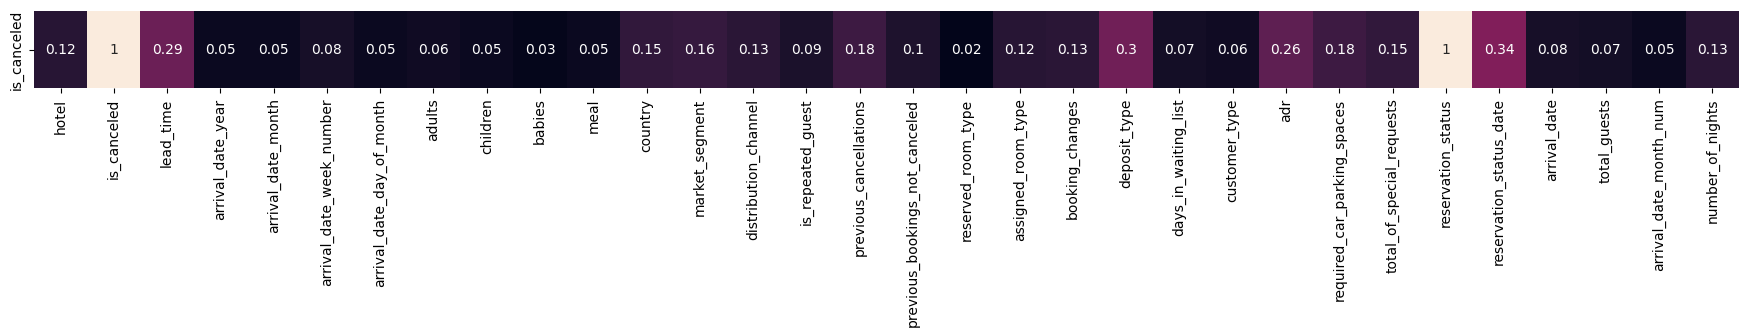

In [21]:
assoc_cr = []
col =  df.columns.tolist()
for i in col: 
    assoc = round(cramers_v(df['is_canceled'], df[i]), 2) 
    assoc_cr.append(assoc)
    
df_cr = pd.DataFrame(data = [assoc_cr], columns = col, index=['is_canceled'])

plt.figure(figsize=(22, 1))
sns.heatmap(df_cr, annot = True, cbar=False)
plt.show()

**Key Insights from the Plots:**

Hasil Korelasi menggunakan `Dython-Cramers_V` didapatkan beberapa variabel yang memiliki korelasi yang cukup kuat dan memiliki Domain Knowledge yang relevan dengan `Booking Cancellation (is_canceled)` diantaranya:

- `Lead Time` : Semakin lama waktu antara pemesanan dan tanggal kedatangan, semakin besar kemungkinan tamu membatalkan pemesanan dan hasil korelasi cukup signifikan sebesar (0.29).

- `Deposit Type` : Tipe deposit (misalnya, No Deposit, Non Refund, Refundable) merupakan indikator penting, karena tamu dengan Non Refund (bayar penuh) lebih cenderung membatalkan dengan korelasi (0.3).

- `Total Special Request` : Semakin banyak permintaan khusus, semakin rendah kemungkinan pembatalan, menunjukkan tamu yang serius dalam pemesanan mereka. Dibuktikan dengan korelasi positif yang cukup kuat (0.15).

- `Previous Cancellations` : Korelasi yang cukup kuat (0.18), mengindikasikan tamu dengan riwayat pembatalan cenderung lebih mungkin membatalkan kembali dan ko

- `ADR (Average Daily Rate)` : Korelasi positif yang cukup kuat (0.26), menunjukkan bahwa harga harian rata-rata yang semakin tinggi dapat memengaruhi keputusan pembatalan.

- `Market Segment` : Beberapa market segment tamu berasal memeiliki korelasi (0.16) cukup signifikan, hal ini diindikasikan tamu yang melakukan pemesanan melalui Online TA memiliki kecenderungan pembatalan pesanan.

- `Country` : Berdasarkan hasil pengklasifikasian, meskinpun tamu internasional banyak melakukan pemesanan tetapi tamu domestik lebih cenderung melakukan pembatalan pesanan dibanding dengan tamu internasional dengan nilai korelasi (0.15)

Dari hasil korelasi ini beberapa akan digunakan sebagai **Feature Selection**

- ## **Feature Selection**

**Features Selection for Modelling Based on Corellation and Domain Knowledge :**

1.  Variabel- Variabel yang memilki nilai korelasi cukup kuat pada pembahasan selanjutnya akan digunakan sebagai features, diantaranya : `Lead Time, Deposit Type, Total Special Request, Previous Cancellations, ADR (Average Daily Rate), Market Segmen, Country`. Sisanya yang memiliki korelasi kuat seperti `Reservation Status, Reservation Status Date` akan di drop karna di cukup relevan untuk dijadikan faktor tamu membatalkan pesanan

2. Selanjutnya Variabel yang memiliki Korelasi Rendah tetapi relevan dengan Domain Knowledge, diantaranya : 

- `Hotel` --> Tipe Hotel dapat memengaruhi pembatalan karena tamu cenderung lebih sering membatalkan di tipe hotel tertentu, misalnya karena lokasi atau tujuan perjalanan.
- `Customer Type` --> Tipe Pelanggan menjadi relevan karena pola reservasi berbeda antar tipe pelanggan, memengaruhi risiko pembatalan.
- `Number of Nights` --> Lama menginap dapat memengaruhi keputusan pembatalan
- `Booking Changes` -->  Jumlah perubahan pada pemesanan menunjukkan ketidakpastian pelanggan, sehingga relevan untuk prediksi pembatalan
- `Days in Waiting List` --> umlah hari di daftar tunggu memengaruhi kesabaran pelanggan, yang dapat menyebabkan pembatalan.
- `Reserved Room Type` --> Jenis kamar yang dipesan penting karena pelanggan mungkin membatalkan jika tidak mendapatkan jenis kamar yang diinginkan.
- `Distribution Channel`--> Distribusi Channel (Online, Offline or Direct) berpengaruh karena pelanggan melalui saluran tertentu cenderung memiliki pola pembatalan berbeda.
- `Required Car Parking Spaces` --> Permintaan ruang parkir relevan karena menunjukkan tamu yang memiliki mobil, yang seringkali lebih pasti dalam kedatangan.
- `Is Repeated Guest` --> Tamu yang tidak pernah menginap sebelumnya (repeat guests) cenderung lebih besar kemungkinannya untuk membatalkan reservasi.

Dan beberapa variabel sisanya kurang relevan baik secara Korelasi atau Domain Knowledge. Meskipun dapat dipertimbangkan untuk kasus tertentu, mereka kemungkinan memiliki dampak rendah pada pembatalan. Maka dari itu, feature yang digunakan ada sebanyak 16 Variabel

In [22]:
features = df.drop(['arrival_date_year','arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month',
                    'reservation_status', 'adults', 'children', 'babies', 'previous_bookings_not_canceled', 'assigned_room_type',
                    'reservation_status_date', 'arrival_date', 'arrival_date_week_number','meal'], axis=1, inplace = True)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54696 entries, 2 to 119387
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   hotel                        54696 non-null  object 
 1   is_canceled                  54696 non-null  int32  
 2   lead_time                    54696 non-null  int64  
 3   country                      54696 non-null  object 
 4   market_segment               54696 non-null  object 
 5   distribution_channel         54696 non-null  object 
 6   is_repeated_guest            54696 non-null  int64  
 7   previous_cancellations       54696 non-null  int64  
 8   reserved_room_type           54696 non-null  object 
 9   booking_changes              54696 non-null  int64  
 10  deposit_type                 54696 non-null  object 
 11  days_in_waiting_list         54696 non-null  int64  
 12  customer_type                54696 non-null  object 
 13  adr                 

- ## **Splitting Features and Target**

In [24]:
x = df.drop(columns=['is_canceled'])
y = df['is_canceled']

In [25]:
x

,hotel,lead_time,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,reserved_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_guests,arrival_date_month_num,number_of_nights
2,Resort Hotel,7,Internasional,Direct,Direct,0,0,A,0,No Deposit,0,Transient,75.00,0,0,1.0,7,1
3,Resort Hotel,13,Internasional,Corporate,Corporate,0,0,A,0,No Deposit,0,Transient,75.00,0,0,1.0,7,1
4,Resort Hotel,14,Internasional,Online TA,TA/TO,0,0,A,0,No Deposit,0,Transient,98.00,0,1,2.0,7,2
5,Resort Hotel,14,Internasional,Online TA,TA/TO,0,0,A,0,No Deposit,0,Transient,98.00,0,1,2.0,7,2
6,Resort Hotel,0,Domestik,Direct,Direct,0,0,C,0,No Deposit,0,Transient,107.00,0,0,2.0,7,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119365,City Hotel,54,Internasional,Direct,Direct,0,0,G,0,No Deposit,0,Transient,266.75,0,1,1.0,8,8
119380,City Hotel,44,Internasional,Online TA,TA/TO,0,0,A,0,No Deposit,0,Transient,140.75,0,1,2.0,8,4
119384,City Hotel,21,Internasional,Offline TA/TO,TA/TO,0,0,A,0,No Deposit,0,Transient,96.14,0,2,2.0,8,7
119385,City Hotel,23,Internasional,Offline TA/TO,TA/TO,0,0,A,0,No Deposit,0,Transient,96.14,0,0,2.0,8,7


- ## **Feature Transfrom**

- **Encoding**
    - `Country` --> Ordinal Encoding --> Nilainya ordinal atau memiliki urutan (Domestik < Internasional), secara jarak dan harga
    - `Reserved Room Type` --> Ordinal Encoding --> Nilainya ordinal atau memiliki urutan
    - `Hotel` -->  One Hot Enconding --> Jumlah uniknya adalah 2, jadi lebih baik menggunakan one hot encoding
    - `Distribution Channel` --> One Hot Encoding --> Jumlah uniknya adalah 3, jadi lebih baik menggunakan one hot encoding
    - `Deposit Type` --> One Hot Encoding --> Jumlah uniknya adalah 4, jadi lebih baik menggunakan one hot encoding
    - `Customer Type` --> One Hot Encoding --> Jumlah uniknya adalah 4, jadi lebih baik menggunakan one hot encoding
    - `Market Segment` --> Binary Encoding --> Jumlah uniknya adalah 7 , jadi lebih baik menggunakan binary encoding


- **Scaling**
    - `Lead Time` --> Robust Scaler
    - `Is Repeated Guest` --> Robust Scaler
    - `Previous Cancellations` --> Robust Scaler
    - `Booking Changes` --> Robust Scaler
    - `Days in Waiting List` --> Robust Scaler
    - `ADR (Average Daily Rate)` -- Robust Scaler
    - `Required Car Parking Space` --> Robust Scaler
    - `Total of Special Request` --> Robust Scaler
    - `Number of Nights` --> Robust Scaler

    Menggunakan **Robust Scaler** karena tidak terlalu dipengaruhi oleh nilai ekstrem (Outlier). Jadi untuk hasil yang lebih baik, kami menggunakan Robust Scaler.

- **Resampling**
    - SMOTE
    - Random Over Sampling
    - Random Under Sampling
    - Near Miss

In [26]:
ordinal_mapping = [{'col':'country', 'mapping':{'Internasional':1, 'Domestik':2}}]

ordinal_mapping2 = [{'col':'reserved_room_type', 'mapping':{'A': 1, 'E' : 2, 'D': 3, 'F': 4, 'B' : 5, 'G': 6, 'C': 7, 'H': 8, 'P': 9}}]

pipe_ordinal_scale = Pipeline([
    ('ordinal', OrdinalEncoder(cols=['country',], mapping=ordinal_mapping)),
    ('min_max_scaler', MinMaxScaler())
])

pipe_ordinal_scale2 = Pipeline([
    ('ordinal', OrdinalEncoder(cols=['reserved_room_type'], mapping=ordinal_mapping2)),
    ('min_max_scaler', MinMaxScaler())
])

transform = ColumnTransformer(transformers=[
            ('onehot_encoder', OneHotEncoder(drop='first'), ['hotel', 'distribution_channel', 'deposit_type', 'customer_type']), 
            ('binary_encoder', BinaryEncoder(), ['market_segment']),
            ('pipe_ordinal_scale2', pipe_ordinal_scale2, ['reserved_room_type']),
            ('pipe_ordinal_scale', pipe_ordinal_scale, ['country']),
            ('robust_scaller', RobustScaler(), ['lead_time','is_repeated_guest','previous_cancellations', 'booking_changes', 'days_in_waiting_list','adr','required_car_parking_spaces', 'total_of_special_requests','number_of_nights'])],
             remainder='passthrough')
transform

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehot_encoder', OneHotEncoder(drop='first'),
                                 ['hotel', 'distribution_channel',
                                  'deposit_type', 'customer_type']),
                                ('binary_encoder', BinaryEncoder(),
                                 ['market_segment']),
                                ('pipe_ordinal_scale2',
                                 Pipeline(steps=[('ordinal',
                                                  OrdinalEncoder(cols=['reserved_room_type'],
                                                                 mapping=[{'col': 'reserved_room_type'...
                                                                 mapping=[{'col': 'country',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': Internasional    1
Domestik         2
dtype: int64}])),
                                                 ('min_max_scaler',
                                                  MinMaxScaler())]),
                                 ['country']),
                                ('robust_scaller', RobustScaler(),
                                 ['lead_time', 'is_repeated_guest',
                                  'previous_cancellations', 'booking_changes',
                                  'days_in_waiting_list', 'adr',
                                  'required_car_parking_spaces',
                                  'total_of_special_requests',
                                  'number_of_nights'])])

- ## **Splitting Data**

In [27]:
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=1811)

In [28]:
testing = pd.DataFrame(transform.fit_transform(X_train),columns=transform.get_feature_names_out())
testing.head()

,onehot_encoder__hotel_Resort Hotel,onehot_encoder__distribution_channel_Direct,onehot_encoder__distribution_channel_GDS,onehot_encoder__distribution_channel_TA/TO,onehot_encoder__deposit_type_Non Refund,onehot_encoder__deposit_type_Refundable,onehot_encoder__customer_type_Group,onehot_encoder__customer_type_Transient,onehot_encoder__customer_type_Transient-Party,binary_encoder__market_segment_0,...,robust_scaller__is_repeated_guest,robust_scaller__previous_cancellations,robust_scaller__booking_changes,robust_scaller__days_in_waiting_list,robust_scaller__adr,robust_scaller__required_car_parking_spaces,robust_scaller__total_of_special_requests,robust_scaller__number_of_nights,remainder__total_guests,remainder__arrival_date_month_num
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,-0.661172,0.0,0.0,-0.333333,2.0,1.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.120078,1.0,0.0,-0.333333,2.0,4.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.083047,0.0,3.0,0.333333,2.0,3.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.864297,0.0,0.0,-0.333333,1.0,11.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.036953,0.0,1.0,0.666667,2.0,11.0


## **Modelling**

---

- ## **Model Benchmarking: K-Fold with Imbalance Treatment**

In [30]:
# Models
logreg = LogisticRegression(random_state=42)
dt = DecisionTreeClassifier(random_state=42)
#Ensemble models
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
lgbm = lgb.LGBMClassifier(random_state=42)

# Imbalance Treatment
ros = RandomOverSampler(random_state=20)
rus = RandomUnderSampler(random_state=20)
smote = SMOTE(random_state=20)
near = NearMiss()


models = {
    'Logistic Regression': logreg,
    'Decision Tree': dt,
    'XGBoost': xgb,
    'Random Forest': rf,
    'Light GBM': lgbm,
}


resamples = {
    'none': None,
    'ros': ros,
    'rus': rus,
    'smote': smote,
    'near miss': near,
}

# Metrics Classification
# Define custom F0.5 score
f05_scorer = make_scorer(fbeta_score, beta=0.5)

metrics = {
    'balanced_accuracy': 'balanced_accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'f0.5': f05_scorer 
}

test_accuracy_arr = []
test_precision_arr = []
test_recall_arr = []
test_f1_arr = []
test_f05_arr = []
list_model = []
list_resample = []

# Iterate over all models, resampling, and cross-validate method
for name_resample, resample in resamples.items():
    for name_model, model in models.items():
        crossval = StratifiedKFold(n_splits=5)

        if resample is None:
            estimator = Pipeline([
                ('preprocessor', transform),
                ('model', model),
            ])
        else:
            estimator = Pipeline([
                ('preprocessor', transform),
                ('resample', resample),
                ('model', model),
            ])

        list_model.append(name_model)
        list_resample.append(name_resample)
        scores = cross_validate(estimator, X_train, y_train, cv=crossval, scoring=metrics)
        test_accuracy_arr.append(scores['test_balanced_accuracy'].mean() * 100)
        test_precision_arr.append(scores['test_precision'].mean() * 100)
        test_recall_arr.append(scores['test_recall'].mean() * 100)
        test_f1_arr.append(scores['test_f1'].mean() * 100)
        test_f05_arr.append(scores['test_f0.5'].mean() * 100)

# Create a dataframe for all of the benchmarking output
model_bench = pd.DataFrame({
    'model': list_model,
    'resample': list_resample,
    'accuracy': test_accuracy_arr,
    'precision': test_precision_arr,
    'recall': test_recall_arr,
    'F1': test_f1_arr,
    'F0.5': test_f05_arr
})

model_bench

[LightGBM] [Info] Number of positive: 8413, number of negative: 26591
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 448
[LightGBM] [Info] Number of data points in the train set: 35004, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240344 -> initscore=-1.150795
[LightGBM] [Info] Start training from score -1.150795
[LightGBM] [Info] Number of positive: 8414, number of negative: 26591
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 450
[LightGBM] [Info] Number of data points in the train set: 35005, number of used features: 25
[LightGBM] [Info] [bin

,model,resample,accuracy,precision,recall,F1,F0.5
0,Logistic Regression,none,65.419515,69.481124,35.818110,47.258570,58.475110
1,Decision Tree,none,75.723605,61.452777,64.191269,62.789574,61.980019
2,XGBoost,none,75.802316,75.341866,57.573514,65.260855,70.954261
3,Random Forest,none,78.253152,77.205707,62.327781,68.972266,73.686778
4,Light GBM,none,75.063380,76.260479,55.605255,64.309283,70.981607
5,Logistic Regression,ros,74.516404,47.785486,74.945140,58.358317,51.518745
6,Decision Tree,ros,75.835964,61.894237,64.172308,63.011484,62.336073
7,XGBoost,ros,80.605578,58.150901,79.262239,67.083563,61.422236
8,Random Forest,ros,79.737421,70.775986,68.413131,69.570937,70.288091
9,Light GBM,ros,80.315175,55.372416,81.392100,65.902495,59.152418


Secara keseluruhan, teknik Resampling (Imbalance Data) seperti `RandomOverSampling` dan `RandomUnderSampling` terbukti efektif dalam meningkatkan kemampuan model mendeteksi kelas minoritas dibandingkan tanpa menggunakan teknik Resampling. Hal ini dapat terlihat dari hasil **Metrics yang mengalami *Perubahan Signifikan***

In [ ]:
# Top 5 Models by F0,5 SCore
top_model = model_bench.sort_values(by='F0.5', ascending=False).head()
top_model

,model,resample,accuracy,precision,recall,F1,F0.5
3,Random Forest,none,77.159013,73.387722,61.357955,66.830885,70.614919
2,XGBoost,none,75.335802,74.910055,56.679599,64.528310,70.379411
4,Light GBM,none,74.846520,74.876063,55.595745,63.808012,70.016774
8,Random Forest,ros,78.460893,66.798059,67.547854,67.162041,66.941086
18,Random Forest,smote,78.584813,66.135043,68.222913,67.159917,66.540561


- ## **Best Models**

In [ ]:
# Sorting for highest Recall
top_recall_per_model = model_bench.loc[model_bench.groupby('model')['F0.5'].idxmax()]
top_recall_per_model = top_recall_per_model.sort_values(by='F0.5', ascending=False)
top_recall_per_model

,model,resample,accuracy,precision,recall,F1,F0.5
3,Random Forest,none,77.159013,73.387722,61.357955,66.830885,70.614919
2,XGBoost,none,75.335802,74.910055,56.679599,64.528310,70.379411
4,Light GBM,none,74.846520,74.876063,55.595745,63.808012,70.016774
1,Decision Tree,none,75.039778,61.255798,62.613024,61.919980,61.518143
0,Logistic Regression,none,65.398268,69.547706,35.751547,47.216772,58.478252


**Best Model Conclusion**

Setelah proses Teknik Resampling dan K-Fold dilakukan, didapatkan dari ke-5 model yang di Benchmark menghasilkan **rata-rata F0.5 model terbesar yaitu dimiliki oleh model `Random Forest Classifier`** dengan **Rata-rata `F0.5 70.61`**. 

Dengan demikian disimpulkan bahwa model terbaik adalah `Random Forest Classifier`. Dan selanjutnya kita akan mencoba mencoba model dengan Data Testing.

- ## **Model to Data Test**

In [ ]:
rf = RandomForestClassifier(random_state=42)

ros = RandomOverSampler(random_state=20)
rus = RandomUnderSampler(random_state=20)
smote = SMOTE(random_state=20)
near = NearMiss()

models = [
    ('Random Forest', rf),
]


resamples = [
    ('none', None),
    ('RandomOverSampling', ros),
    ('RandomUnderSampling', rus),
    ('smote', smote),
    ('near miss', near)
]


metrics = []
conf_matrix = []

for name_model, model in models:
    for name_resample, resample in resamples:
        pipeline = Pipeline([
            ('transformer', transform),  
            ('resampling', resample),
            ('model', model)
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        metrics.append([
            f'{name_model} with {name_resample}',
            accuracy_score(y_test, y_pred) * 100,
            precision_score(y_test, y_pred) * 100,
            recall_score(y_test, y_pred) * 100,
            f1_score(y_test, y_pred) * 100,
            fbeta_score(y_test, y_pred, beta=0.5) * 100
        ])

        conf_matrix.append(confusion_matrix(y_test, y_pred))
        
metrics_df = pd.DataFrame(metrics, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'F0.5'])
metrics_df

,Model,Accuracy,Precision,Recall,F1,F0.5
0,Random Forest with none,86.133455,75.481210,62.647394,68.468094,72.510346
1,Random Forest with RandomOverSampling,84.990859,69.017341,68.124762,68.568147,68.836959
2,Random Forest with RandomUnderSampling,80.082267,55.886970,81.247623,66.222291,59.608193
3,Random Forest with smote,84.451554,67.352281,68.505135,67.923817,67.579737
4,Random Forest with near miss,48.372943,29.084107,79.840243,42.636604,33.320634


In [ ]:
metrics_df['Model'] = metrics_df['Model'].replace({
    'Random Forest with RandomOverSampling': 'Random Forest Before Tune'
})

metrics_df_selected = metrics_df[metrics_df['Model'] == 'Random Forest Before Tune']
metrics_df_selected

,Model,Accuracy,Precision,Recall,F1,F0.5
0,Random Forest Before Tune,84.990859,69.017341,68.124762,68.568147,68.836959


Pada hasil Testing Random Forest didapatkan Model dengan None Resampling memiliki nilai F0.5 Score yang lebih tinggi dibandingkan Resampling lainnya, akan tetapi pada kasus ini dikarenakan terjadi Imbalance Data pada Kolom target. Hal yang akan terjadi ketika Imbalance tidak diatasi, metrik model akan memberikan interpretasi yang keliru karena model akan cenderung memprediksi kelas yang dominan. Maka selanjutnya **Model Random Forest yang akan digunakan adalah dengan `Resampling RandomOverSampling`** dengan nilai F0.5 lebih baik dibawahnya dari None Resamping.

Dan kemudian akan dilakukan **Hyperparameter Tuning** menggunakan model `Random Forest Classifier` yang diharapkan memberikan hasil yang lebih baik.

- ## **Hyperparameter Tuning: Random Forest Classifier**

In [ ]:
rf = RandomForestClassifier(random_state=42)
ros = RandomOverSampler(random_state=20)

pipe_model = Pipeline([
    ('prep', transform),  
    ('resampling', ros),
    ('model', rf)
])

# Mendefinisikan Hyperparameter Space
hyperparam_space = {
    'model__n_estimators': [100, 150],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
    'model__max_features': ['auto', 'sqrt', 'log2'],
}

# Definisikan Grid Search
gscv = GridSearchCV(
    estimator=pipe_model,
    param_grid=hyperparam_space,
    cv=5,
    scoring= f05_scorer,
    n_jobs=-1
)

gscv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot_encoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['hotel',
                                                                          'distribution_channel',
                                                                          'deposit_type',
                                                                          'customer_type']),
                                                                        ('binary_encoder',
                                                                         BinaryEncoder(),
                                                                         ['market_segment']),
                                                                        ('pipe_ordinal_scale2',
                                                                         Pipeline(steps=[('ordinal',
                                                                                          OrdinalEncoder(cols=['reser...
                                        RandomOverSampler(random_state=20)),
                                       ('model',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 10, 20],
                         'model__max_features': ['auto', 'sqrt', 'log2'],
                         'model__min_samples_leaf': [1, 2],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [100, 150]},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=0.5))

In [ ]:
# Output the best parameters and best score
best_params = gscv.best_params_
best_score = gscv.best_score_

print("Best Parameters:", best_params)
print("Best F0.5 Score:", best_score)

Best Parameters: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 150}
Best F0.5 Score: 0.6723859182214303


In [ ]:
rf_tuning = gscv.best_estimator_
rf_tuning.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot_encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['hotel',
                                                   'distribution_channel',
                                                   'deposit_type',
                                                   'customer_type']),
                                                 ('binary_encoder',
                                                  BinaryEncoder(),
                                                  ['market_segment']),
                                                 ('pipe_ordinal_scale2',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(cols=['reserved_room_type'],
                                                                                  mapping=[{'c...
                                                 ('robust_scaller',
                                                  RobustScaler(),
                                                  ['lead_time',
                                                   'is_repeated_guest',
                                                   'previous_cancellations',
                                                   'booking_changes',
                                                   'days_in_waiting_list',
                                                   'adr',
                                                   'required_car_parking_spaces',
                                                   'total_of_special_requests',
                                                   'number_of_nights'])])),
                ('resampling', RandomOverSampler(random_state=20)),
                ('model',
                 RandomForestClassifier(min_samples_split=5, n_estimators=150,
                                        random_state=42))])

In [ ]:
y_pred_rf_tuning = rf_tuning.predict(X_test)

accuracy_rf_tuning = accuracy_score(y_test, y_pred_rf_tuning) * 100
precision_rf_tuning = precision_score(y_test, y_pred_rf_tuning) * 100
recall_rf_tuning = recall_score(y_test, y_pred_rf_tuning) * 100
f1_rf_tuning = f1_score(y_test, y_pred_rf_tuning) * 100
f05_rf_tuning = fbeta_score(y_test, y_pred_rf_tuning, beta=0.5) * 100

rf_after_tuning = pd.DataFrame({
    'Model': ['Random Forest After Tuning'],
    'Accuracy': [accuracy_rf_tuning],
    'Precision': [precision_rf_tuning],
    'Recall': [recall_rf_tuning],
    'F1': [f1_rf_tuning],
    'F0.5': [f1_rf_tuning]
})


metrics_df_selected = metrics_df_selected.reset_index(drop=True)

# Concat DataFrame with Metrics Before Tune
metrics_combined = pd.concat([rf_after_tuning, metrics_df_selected], ignore_index=True)
metrics_combined

,Model,Accuracy,Precision,Recall,F1,F0.5
0,Random Forest After Tuning,85.054845,68.911720,68.885508,68.898611,68.898611
1,Random Forest Before Tune,84.990859,69.017341,68.124762,68.568147,68.836959


Setelah dilakukan Hyparameter Tuning **F0.5 meningkat tipis dari 68.83% sebelum tuning menjadi 68.89% setelah tuning**. Meskipun peningkatannya sangat kecil, hal ini menunjukkan bahwa model yang telah di-tuning sedikit lebih baik dalam menyeimabangkan pelanggan yang akan cancel dan reservasi, yang penting untuk strategi manajemen hotel. Meskipun ada trade-off dalam hal accuracy dan precision, peningkatan F0.5 ini mengindikasikan bahwa model setelah tuning sedikit lebih efektif dalam mendeteksi kasus booking cancellation.

- ## **Train and Test Model After Tuning**

In [ ]:
# Compute recall on the training set
train_pred = rf_tuning.predict(X_train)
train_precision = precision_score(y_train, train_pred)
train_f05 = fbeta_score(y_train, train_pred, beta=0.5)

# Compute recall on the test set
test_pred = rf_tuning.predict(X_test)
test_precision = precision_score(y_test, test_pred)
test_f05 = fbeta_score(y_test, test_pred, beta=0.5)

# Create a DataFrame with the results
df_results = pd.DataFrame({
    'model': ['Random Forest After Tuning'],
    'Train F0.5': [train_f05],
    'Test F0.5': [test_f05],
    'Train Precision': [train_precision],
    'Test Precision': [test_precision]
}).set_index('model')


df_results

,Train F0.5,Test F0.5,Train Precision,Test Precision
model,,,,
Random Forest After Tuning,0.945051,0.689065,0.936801,0.689117


**Model Conclusion**

Model `Random Forest Classifier` dengan `RandomOverSampler` setelah tuning menunjukkan performa yang cukup berbeda dengan skor F0.5 training dan testing saling berjauhan (94.5 - 68.9). Hal ini dapat dikatakan bahwa model mengalami *`over fitting`*, yang mengindikasikan kemampuan generalisasi yang baik hanya pada data training. Tetapi secara keseluruhan, fenomena ini dapat dianggap wajar dengan mengasumsikan data test lebih bervariatif. Maka model ini dapat dianggap cukup baik untuk mendeteksi booking cancellation dengan berbagai faktornya, terutama jika fokus utama adalah meminimalisir kesalahan deteksi.

- ## **Evaluation Metrics**

**Confusion Matrix**

In [ ]:
# Evaluation with Best Estimator
y_pred_test = gscv.best_estimator_.predict(X_test)

print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))


              precision    recall  f1-score   support

           0       0.90      0.90      0.90      8311
           1       0.69      0.69      0.69      2629

    accuracy                           0.85     10940
   macro avg       0.80      0.80      0.80     10940
weighted avg       0.85      0.85      0.85     10940

[[7494  817]
 [ 818 1811]]


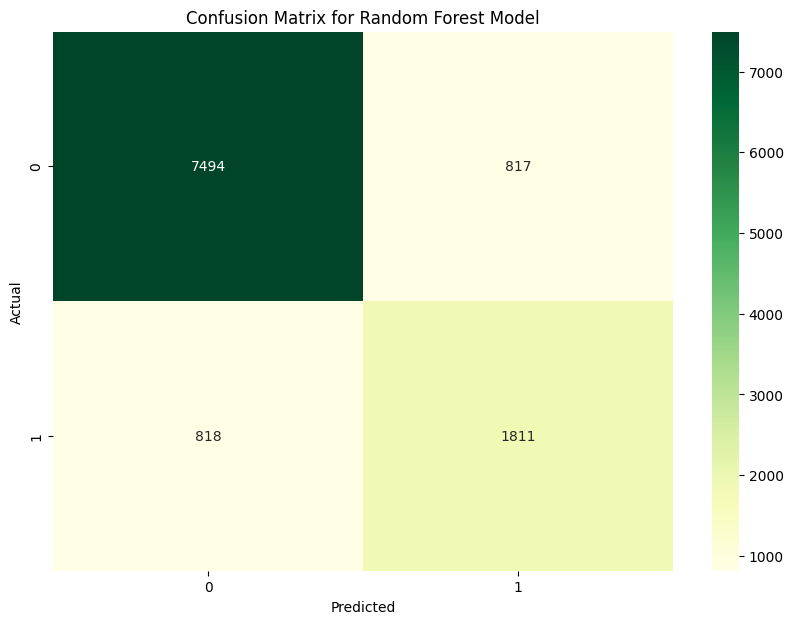

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGn')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

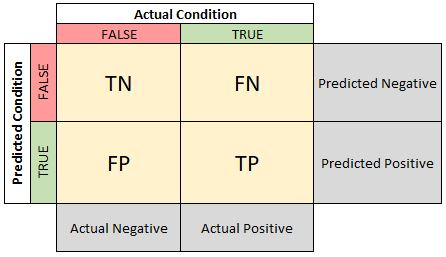

- ## **Feature Importance**

In [ ]:
# Define Logistic Regression and RandomUnderSampler
rf = RandomForestClassifier(random_state=42)
ros = RandomOverSampler(random_state=20)

# Create pipeline using imblearn
estimator = Pipeline([
    ('prep', transform),
    ('resample', rus),
    ('model', logreg)
])
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)

# Evaluate
test_f05 = fbeta_score(y_test, y_pred, beta=0.5)

<AxesSubplot: title={'center': 'Feature Coefficients of the FINAL MODEL'}>

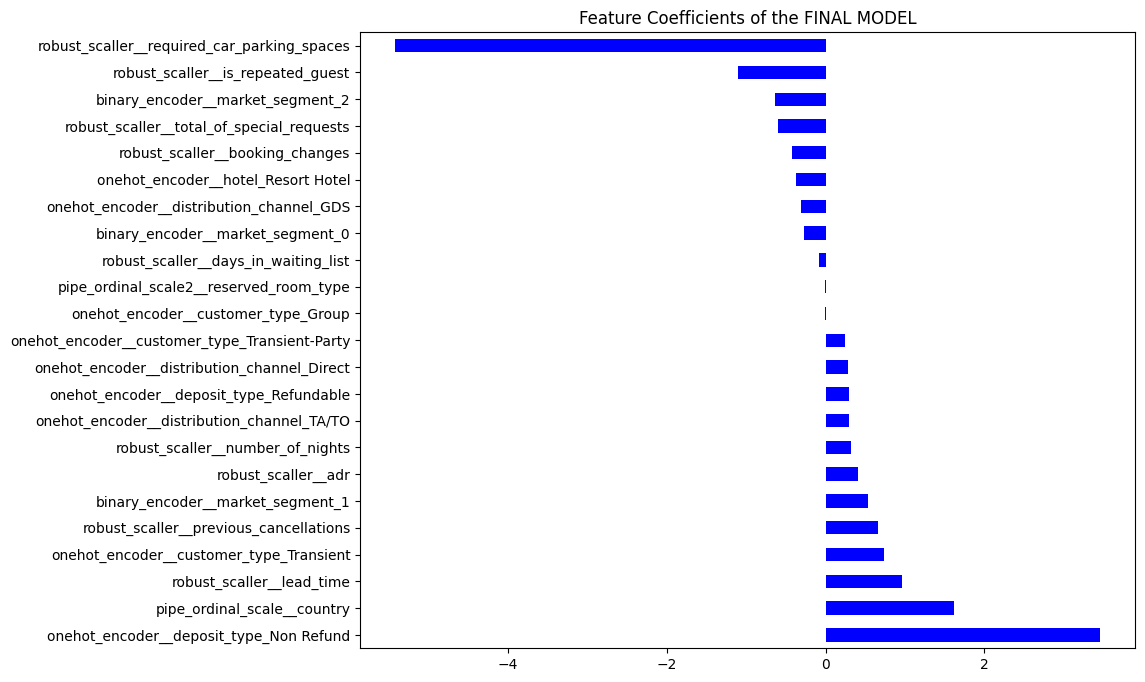

In [ ]:
plt.figure(figsize=(10, 8))

coef = pd.Series(estimator['model'].coef_[0], transform.get_feature_names_out()).sort_values(ascending = False)
coef.plot(kind='barh', title='Feature Coefficients of the FINAL MODEL', color='blue')

### **Koefisien Feature Random Forest Classifier:**

Dari Feature Importance menunjukkan koefisien fitur model untuk Booking Cancellation, dengan tanda ***positif** menunjukkan peningkatan probabilitas Cancellation* dan tanda ***negatif** menunjukkan penurunan probabilitas Cancellation.*

1. **Fitur dengan koefisien negatif besar**:

    - `required car parking spaces`: Kebutuhan akan tempat parkir memiliki dampak negatif yang signifikan terhadap Cancellation. Hal ini mungkin menunjukkan bahwa pelanggan yang memerlukan fasilitas ini lebih cenderung untuk tetap melakukan reservasi karna ruang parkir yang banyak tersedia.
    - `is repeated guest` : Pelanggan yang merupakan tamu berulang cenderung lebih sedikit membatalkan, mungkin karena mereka sudah mengenal layanan hotel.

2. **Fitur dengan koefisien positif besar**:

    - `Non Refund`: Deposit yang tidak dapat dikembalikan meningkatkan kemungkinan pembatalan secara signifikan. Hal ini dapat mencerminkan bahwa pelanggan yang memilih opsi ini mungkin lebih tidak pasti dalam rencana mereka.
    - `Lead Time`: Lead time yang lebih lama juga terkait dengan peningkatan probabilitas pembatalan. Pelanggan yang memesan jauh hari tampaknya memiliki lebih banyak waktu untuk mengubah atau membatalkan reservasi mereka.

3. **Fitur lain yang memiliki pengaruh**:

    - `adr (Average Daily Rate)`: Semakin tinggi ADR, semakin besar kemungkinan pembatalan, mungkin karena harga yang tinggi dapat mempengaruhi keputusan pelanggan.
    - `distribution channel`: Reservasi melalui Travel Agent/Operator meningkatkan kemungkinan pembatalan. Hal memungkinan pemesanan yang melalui TA/TO rentan terhadap pembatalan karna beberapa fleksibelitas yang didapatkan
    - `total of special requests`: Jumlah permintaan khusus yang lebih banyak cenderung mengurangi probabilitas pembatalan, yang mungkin mencerminkan komitmen pelanggan terhadap rencana reservasi mereka.
    - `booking changes`: Adanya perubahan dalam pemesanan juga cenderung menurunkan kemungkinan pembatalan.



In [ ]:
joblib.dump(gscv.best_estimator_, 'model_prediction.pkl')

['model_prediction.pkl']

## **Impact to Business**

---

# **Analisis Pengurangan Kerugian dengan Machine Learning**

---

## **1. Precision dan Recall**
- **Precision:** 68.91%  
- **Recall:** 68.89%  

---

## **2. Persentase Pembatalan**
- **Persentase Pembatalan (Berdasarkan Data):** 27.7%  

---

## **3. Asumsi: Confusion Matrix dan Total Pemesanan**
- **Total Pemesanan:** 54,696

| **Prediksi →**       | **Tidak Membatalkan (0)** | **Membatalkan (1)** | **Total** |
|------------------------|---------------------------|----------------------|-----------|
| **Aktual Tidak Membatalkan (0)** | **34,838 (TN)**         | **4708 (FP)**          | **39,546**  |
| **Aktual Membatalkan (1)**       | **4,713 (FN)**           | **10,437 (TP)**        | **15,150**  |
| **Total**             | **39,551**                | **15,145**            | **54,696** |

---

## **4. Kerugian dari False Negatives (FN)**
False Negatives terjadi ketika pembatalan aktual tidak terdeteksi oleh model, sehingga kehilangan pendapatan.

- **FN Count:** 4,713 
- **Kerugian per FN:** $100  

$$
\text{Kerugian FN} = \text{FN Count} \times \text{Kerugian per FN}
$$

$$
\text{Kerugian FN} = 4,713 \times 100 = \$471,300
$$

---

## **5. Potensi Keuntungan dari False Positives (FP)**
False Positives terjadi ketika pemesanan dianggap dibatalkan, tetapi sebenarnya tidak. Keuntungan dihitung berdasarkan rata-rata tingkat okupansi hotel di Portugal.

- **FP Count:** 4,708  
- **Tingkat Okupansi Rata-rata:** 59.0%  
- **Nilai Kamar:** $100  
- **Biaya Operasional:** $50  

$$
\text{Keuntungan Bersih per FP} = (\text{Tingkat Okupansi} \times \text{Nilai Kamar}) - \text{Biaya Operasional}
$$

$$
\text{Keuntungan Bersih per FP} = (0.59 \times 100) - 50 = \$9
$$

$$
\text{Total Keuntungan dari FP} = \text{FP Count} \times \text{Keuntungan Bersih per FP}
$$

$$
\text{Total Keuntungan dari FP} = 4,708 \times 9 = \$42,372
$$

---

## **6. Kerugian Total Tanpa Machine Learning**
Tanpa model, kerugian dihitung berdasarkan persentase pembatalan dan total pemesanan.

$$
\text{Kerugian Tanpa ML} = \text{Persentase Pembatalan} \times \text{Total Pemesanan} \times \text{Nilai Kamar}
$$

$$
\text{Kerugian Tanpa ML} = 0.277 \times 54,696 \times 100 = \$1,515,079
$$

---

## **7. Kerugian Total Setelah Machine Learning**
Setelah menggunakan model, kerugian dihitung dengan mempertimbangkan kerugian dari FN dan keuntungan dari FP.

$$
\text{Kerugian Setelah ML} = \text{Kerugian FN} - \text{Keuntungan FP}
$$

$$
\text{Kerugian Setelah ML} = 471,300 - 42,372 = \$428,928
$$

---

## **8. Pengurangan Kerugian dengan Machine Learning**
Pengurangan kerugian dihitung dengan membandingkan kerugian sebelum dan setelah menggunakan model.

$$
\text{Pengurangan Kerugian} = \text{Kerugian Tanpa ML} - \text{Kerugian Setelah ML}
$$

$$
\text{Pengurangan Kerugian} = 1,515,079 - 428,928 = \$1,086,151
$$

---

# **Kesimpulan**
Dengan menggunakan machine learning:
1. **Kerugian Total Tanpa ML:** \$1,515,079  
2. **Kerugian Total Setelah ML:** \$428,928 
3. **Pengurangan Kerugian:** \$1,086,151 atau sebanyak 71.6%


<div style="display: flex; justify-content: center;">

|                      | Total Loss            |
|----------------------|-----------------------|
| **Setelah modeling** | $428,928          |
| **Tanpa modeling**     | $1,515,079             |

</div>


## **CONCLUTION & RECOMMENDATION 💡**

---

- ## **Conclution**

### **1. Data Limitation**

Dalam analisis dan pengembangan model prediksi, batasan dataset diperlukan untuk meningkatkan relevansi dan keandalan. Lead time dibatasi antara 20-60 hari untuk fokus pada pemesanan reguler, menghapus data dengan **lead time lebih dari 60 hari**. **Zero occupancy (tamu = 0)** dihapus karena tidak logis dan tidak relevan. Untuk A**DR (Average Daily Rate), hanya data dengan nilai realistis (0-1000)** yang digunakan, menghindari kesalahan atau outlier. Batasan ini memastikan data yang konsisten dan relevan untuk menghasilkan prediksi yang akurat.

### **2. Machine Learning Model**
- Models: Random Forest Classifier

Random Forest adalah algoritma machine learning yang bekerja dengan membangun kumpulan pohon keputusan (decision trees) dan menggabungkan hasilnya untuk meningkatkan akurasi dan mengurangi risiko overfitting. Algoritma ini menggunakan teknik bootstrap sampling untuk membuat subset data pelatihan dan random feature selection untuk membangun setiap pohon, sehingga menghasilkan model yang lebih robust dan stabil. Random Forest juga mendukung evaluasi pentingnya fitur (feature importance) dan dapat menangani dataset dengan dimensi tinggi serta fitur kategori.

- Cara kerja pada kasus ini: 

Seperti yang ditunjukkan pada bagian eksperimen model, sebelum dilakukan tuning, model menggunakan Stratified Cross Validation untuk memastikan distribusi kelas yang seimbang dalam data pelatihan dan pengujian. Pada tahap ini, model mendapatkan hasil terbaik dengan menggunakan metrik F0.5 Score, yang lebih menekankan pada presisi dibandingkan recall.

Namun, setelah dilakukan tuning parameter, model mengalami overfitting, dengan perbedaan signifikan antara performa pada data pelatihan dan validasi. Hal ini menunjukkan bahwa meskipun model bekerja sangat baik pada data pelatihan, kemampuan generalisasi terhadap data baru menjadi kurang optimal. Regularisasi lebih lanjut mungkin diperlukan untuk mengatasi masalah ini.

### **3. Model Preprocess**

Dalam langkah-langkah preprocessing, berbagai teknik digunakan untuk memastikan data diproses secara optimal sebelum dimasukkan ke dalam model

- OneHotEncoder : Digunakan untuk fitur yang hanya memiliki kategori <5, mengubah data kategori menjadi bentuk numerik biner agar dapat diproses dengan efektif oleh model.
- BinaryEncoder : Digunakan untuk fitur kategori dengan banyak nilai unik (high-cardinality), mengubahnya menjadi format biner. Teknik ini membantu mengurangi dimensi data sambil tetap mempertahankan informasi yang ada.
- OrdinalEncoder : Digunakan untuk fitur kategori yang memiliki urutan atau hierarki nilai tertentu. Encoder ini mengonversi data kategori menjadi nilai numerik berdasarkan urutannya, sehingga model dapat mengenali hubungan antar kategori.
- RobustScaler: Digunakan untuk fitur numerik karena kemampuannya yang tahan terhadap outlier, sehingga model tidak terpengaruh oleh nilai ekstrem yang dapat menyebabkan bias.

Pemilihan teknik preprocessing ini bertujuan untuk memastikan bahwa data yang dimasukkan ke dalam model telah diproses secara optimal. Dengan demikian, model dapat belajar secara efektif tanpa dipengaruhi oleh outlier, dimensi data yang tinggi, atau kesalahan akibat kategori yang tidak dikenal.

- ## **Recommendation**

### **1. Memperketat Refund di City Hotel**

Dengan tingkat pembatalan City Hotel sebesar 66.8%, terapkan kebijakan refund yang lebih untuk pembatalan mendadak (contoh H-1 tidak dapat refund).

### **2.Penawaran Eksklusif Musim Panas Resort Hotel**

Cancellation Rate Resort Hotel naik hingga 28.76% di Juli; tambahkan aktivitas berbayar seperti tur pantai.

### **3. Program Loyalitas Tamu Lama di Resort Hotel**

Mayoritas tamu Resort menginap >4 malam; berikan fasilitas gratis seperti makan malam untuk memperkuat loyalitas.

### **4. Langkah Selanjutnya untuk Perbaikan**

- Tambahkan lebih banyak model untuk meningkatkan benchmarking dan evaluasi performa.
- Eksplorasi metode resampling tambahan untuk menangani ketidakseimbangan kelas.
- Temukan model yang mampu mencapai akurasi atau recall lebih tinggi.
- Perkuat kemampuan prediksi dengan menambahkan interaksi antar fitur yang relevan.